In [2]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES


# Explore:
<list>
    <li>Inclusion of altitude information</li>
    <li>Inclusion of seasonality indicator (dry/wet)</li>
    <li>Linear interpolation</li>
    <li>Use 6 reanalysis observations</li>
</list>

# Q1. Does the inclusion of altitude information help the models perform better?

In [3]:
# Load the dataset
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")
df_data_original = pd.read_csv(f"{BASE_DIR}/dataset.csv")

# make sure there is no NaN value
assert df_data_original.isnull().values.any() == False
print(f"There are {df_data_original.shape[0]} samples.")
print(
    "Each sample is associated with lat and lon coordinates.\n" + 
    "Use only the closest observation to represent each field, from 16 different NetCDF files.", )

There are 865561 samples.
Each sample is associated with lat and lon coordinates.
Use only the closest observation to represent each field, from 16 different NetCDF files.


In [4]:
df_combined = df_data_original.merge(right=df_metadata[["SKN", "ElevFT"]], left_on="skn", right_on="SKN")
df_clean = (
    df_combined.drop(
        labels=["lat", "lon", "year", "month", "SKN", "skn", "Lon_DD_updated"],
        axis=1
    ).rename(
        columns={"Lat_DD": "lat", "Lon_DD": "lon", "ElevFT": "elev"}
    )
)

In [5]:
# split the dataset without "elev"
X = np.array(df_clean.drop(labels=["data_in", "elev"], axis=1))
Y = np.array(df_clean["data_in"])

Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25, random_state=42)

In [8]:
mse_default = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in", "elev"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_default.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [9]:
mse_w_elev = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_w_elev.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [11]:
np.mean(mse_default), np.mean(mse_w_elev), np.std(mse_default), np.std(mse_w_elev)

(32.68191211413612, 32.49858541729416, 0.4200438533978725, 0.3920811096025575)

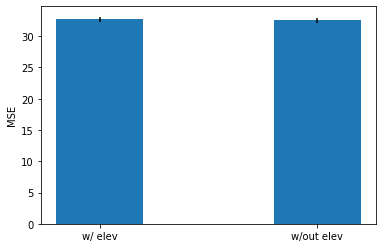

In [18]:
fig, ax = plt.subplots()
ax.bar(
    x=np.arange(2),
    height=[np.mean(mse_default), np.mean(mse_w_elev)],
    yerr=[np.std(mse_default), np.std(mse_w_elev)],
    width=0.4,
)
ax.set_xticks(np.arange(2))
ax.set_xticklabels(["w/ elev", "w/out elev"])
ax.set_ylabel("MSE")
print()

## Q1.2 Random Forest

In [23]:
# 6/2/2 split
X = np.array(df_clean.drop(labels=["data_in"], axis=1))
Y = np.array(df_clean["data_in"])
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25, random_state=42)

In [25]:
random_forest = RandomForestRegressor(n_jobs=-1, verbose=True)
random_forest.fit(Xtrain, Ytrain)
# mean_squared_error(Yvalid, random_forest.predict(Xvalid))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


6.917907535860025

In [26]:
print("The default performance (MSE) is {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


The default performance (MSE) is 6.918


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


In [32]:
params = {
    "n_estimators": 200, #(150, 200)
    "max_depth": None, #(None)
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_jobs": -1,
    "verbose" : True
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
print("MSE on validation set is {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s


MSE on validation set is 6.827


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    4.6s finished


## Q1.3 XGBoost

In [34]:
params = {
    "learning_rate": 1, # [0.05, 1.0]
    "n_estimators": 300,# [100, 300]
    "subsample": 0.8,
    "max_depth": 4, # [1, 4]
    "loss": "squared_error",
    "verbose": True
}

gradient_boost = GradientBoostingRegressor(**params)
gradient_boost.fit(Xtrain, Ytrain)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          31.5867           9.2261            9.35m
         2          27.5960           3.6942            8.98m
         3          24.6420           3.3282            8.84m
         4          23.4939           1.0139            8.90m
         5          22.6736           0.7018            9.00m
         6          22.5010           0.2989            9.01m
         7          20.6494           1.7806            8.86m
         8          20.1566           0.4448            8.77m
         9          19.7160           0.3999            8.74m
        10          19.6485           0.2163            8.66m
        20          17.2068           0.0843            8.00m
        30          15.6877           0.0643            7.62m
        40          14.6201           0.0532            7.34m
        50          13.6686           0.0469            7.00m
        60          13.2185           0.0143            6.71m
       

GradientBoostingRegressor(learning_rate=1, max_depth=4, n_estimators=300,
                          subsample=0.8, verbose=True)

In [36]:
print("MSE on validation set is {:.3f}".format(mean_squared_error(Yvalid, gradient_boost.predict(Xvalid))))

MSE on validation set is 9.976


# Q2. How does the performance change if we smooth out the observation of reanalysis data?
We can smooth out the observation using linear interpolation. For this, 5x5 grid of observations around hawaii was used to make the resolution higher.

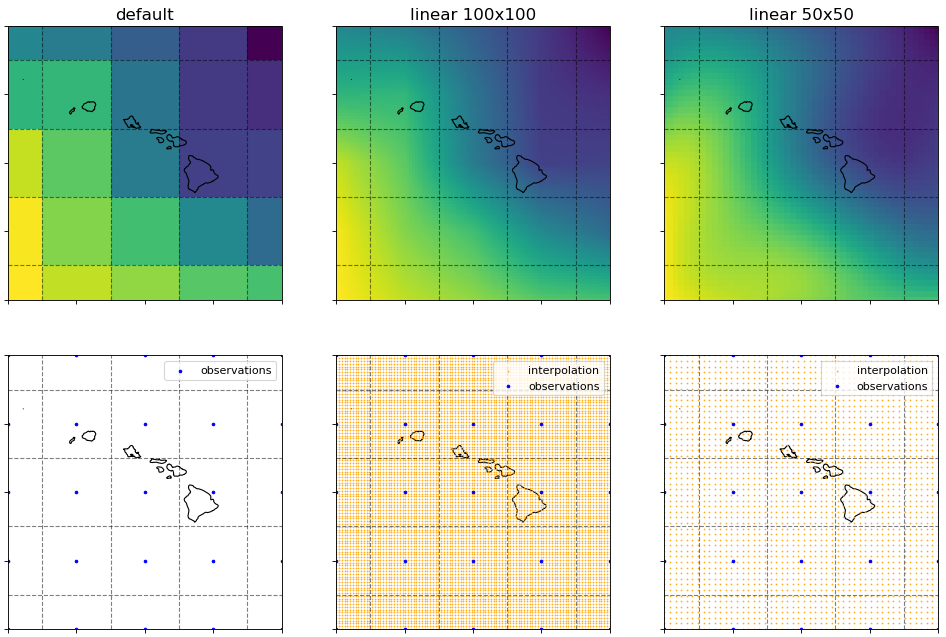

In [51]:
# load a sample dataset
ds_air2m = xr.open_dataset(f"{BASE_DIR}/air.2m.mon.mean.regridded.nc")
data_matrix = ds_air2m.loc[dict(time="1948-06-01", lon=np.array(lon_hawaii) + 360, lat=lat_hawaii)]["air"]

# apply linear interpolation
data_matrix_interp_100 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="linear"
)

data_matrix_interp_50 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    50
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    50
    ) + 360,
    method="cubic"
)

fig, axs = plt.subplots(
    2, 3, figsize=(15, 10), dpi=80,
    subplot_kw={'projection': ccrs.PlateCarree()},
)

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

data_matrix.plot(ax=axs[0, 0], add_colorbar=False)
data_matrix_interp_100.plot(ax=axs[0, 1], add_colorbar=False)
data_matrix_interp_50.plot(ax=axs[0, 2], add_colorbar=False)

for ax in axs.flatten():
    ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
    ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
    ax.set_ylabel("")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.coastlines(resolution='10m')
    ax.grid(linewidth=2, color='black', linestyle='--')
    ax.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
axs[0, 0].set_title("default", fontsize=(15))
axs[0, 1].set_title("linear 100x100", fontsize=(15))
axs[0, 2].set_title("linear 50x50", fontsize=(15))


# lower plots
lat_hawaii = [15, 17.5, 20, 22.5, 25]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

xx_interp_50, yy_interp_50 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 50),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 50)
)

xx_interp_100, yy_interp_100 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 100),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 100)
)

interpolation = axs[1, 1].scatter(xx_interp_100, yy_interp_100, s=0.3, label="interpolation", color='orange')
interpolation = axs[1, 2].scatter(xx_interp_50, yy_interp_50, s=0.3, label="interpolation", color='orange')

for i in range(3):
    observations = axs[1, i].scatter(xx, yy, s=5, label="observations", color='blue')
    axs[1, i].legend(loc=1)

print()

## Q2.1 Linear Regression with higher resolution

In [37]:
df_interp_100 = pd.read_csv(f"{BASE_DIR}/dataset_interp_100.csv")

In [38]:
df_i100 = df_interp_100.drop(labels=["skn", "year", "month", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"], axis=1)
Y = df_i100["data_in"]
X = df_i100.drop(["data_in"], axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))


MSE: 35.813


## Q2.2 Random Forest with higher resolution

In [43]:
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25, random_state=42)
random_forest = RandomForestRegressor(n_jobs=-1, verbose=-1)
random_forest.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s


MSE: 6.905


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


In [44]:
params = {
    "n_estimators": 200, #(150, 200)
    "max_depth": None, #(None)
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_jobs": -1,
    "verbose" : True
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
print("MSE on validation set is {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s


MSE on validation set is 6.886


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.2s finished


In [ ]:
# include altitude information and compare models
# Increase the resolution, and choose the closest grid cell
# VERYFY THAT 100 and 50 ARE CORRECT
# 

In [52]:
df_interp_50 = pd.read_csv(f"{BASE_DIR}/dataset_interp_100.csv")
df_i50 = df_interp_50.drop(labels=["skn", "year", "month", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"], axis=1)
Y = df_i50["data_in"]
X = df_i50.drop(["data_in"], axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))


MSE: 35.858


In [46]:
# default model
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.25, random_state=42)
random_forest = RandomForestRegressor(n_jobs=-1, verbose=True)
random_forest.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


MSE: 6.937


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


In [ ]:
params = {
    "n_estimators": 200, #(150, 200)
    "max_depth": None, #(None)
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_jobs": -1,
    "verbose" : True
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
print("MSE on validation set is {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min


# Q3. How does the performance change if we feed more reanalysis data from neighboring 6 grids?

In [15]:
df_6grids = pd.read_csv(f"{BASE_DIR}/dataset_5girds.csv")

In [16]:
df_6g = df_6grids.drop(
    labels=["skn", "year", "month", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"],
    axis=1
)
df_6g = df_6g.drop(
    labels=[
        "air2m", "air1000_500", "hgt500", "hgt1000", "omega500",
        "pottemp1000-500", "pottemp1000-850", "pr_wtr", "shum-uwnd-700",
        "shum-uwnd-925", "shum-vwnd-700", "shum-vwnd-950", "shum700",
        "shum925", "skt", "slp"
    ],
    axis=1
)

In [19]:
df_6g.head()

,data_in,lat,lon,elevation,air2m_0,air2m_1,air2m_2,air2m_3,air2m_4,air2m_5,...,skt_2,skt_3,skt_4,skt_5,slp_0,slp_1,slp_2,slp_3,slp_4,slp_5
0,3.200000,18.916176,-155.674994,35.0,295.72696,295.30087,295.39603,295.29828,294.96295,294.85797,...,23.385218,23.6341,23.194658,23.052715,1014.1755,1013.94574,1014.0849,1015.1941,1014.69965,1014.4063
1,5.950000,19.108660,-155.825545,1750.0,295.72696,295.30087,295.39603,295.29828,294.96295,294.85797,...,23.385218,23.6341,23.194658,23.052715,1014.1755,1013.94574,1014.0849,1015.1941,1014.69965,1014.4063
2,11.500000,19.164740,-155.682280,4890.0,295.72696,295.30087,295.39603,295.29828,294.96295,294.85797,...,23.385218,23.6341,23.194658,23.052715,1014.1755,1013.94574,1014.0849,1015.1941,1014.69965,1014.4063
3,5.515941,19.160603,-155.822488,2940.0,295.72696,295.30087,295.39603,295.29828,294.96295,294.85797,...,23.385218,23.6341,23.194658,23.052715,1014.1755,1013.94574,1014.0849,1015.1941,1014.69965,1014.4063
4,4.310617,19.225323,-155.778876,5680.0,295.72696,295.30087,295.39603,295.29828,294.96295,294.85797,...,23.385218,23.6341,23.194658,23.052715,1014.1755,1013.94574,1014.0849,1015.1941,1014.69965,1014.4063


In [20]:
Y = df_6g["data_in"]
X = df_6g.drop(["data_in"], axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

MSE: 34.049


In [ ]:
params = {
    "n_estimators": 200, #(150, 200)
    "max_depth": None, #(None)
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "n_jobs": -1,
    "verbose" : True
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(Xtrain, Ytrain)
print("MSE on validation set is {:.3f}".format(mean_squared_error(Yvalid, random_forest.predict(Xvalid))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
